###### Imports


In [3]:
# Imports
from qiime2 import Metadata
import pandas as pd
from qiime2 import Artifact, sdk
from qiime2.plugins.dada2.methods import denoise_pyro # The samples were obtained through pyrosequencing
import qiime2.plugins.vsearch.methods as vsm
import qiime2.plugins.phylogeny.methods as pm
from qiime2.plugins import phylogeny
from qiime2.plugins.alignment.methods import mafft
import qiime2.plugins.metadata.actions as metadata_actions
import qiime2.plugins.feature_classifier.actions as feature_classifier_actions
from qiime2.plugins.feature_classifier.pipelines import classify_consensus_vsearch
from qiime2.plugins.feature_classifier.pipelines import classify_consensus_blast
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
import qiime2.plugins.feature_table.actions as fta
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO


In [4]:
# Useful functions
matplotlib.use('module://ipykernel.pylab.backend_inline')
pm = sdk.PluginManager()
def see(artifact):
    from_format = artifact.format
    if issubclass(from_format, sdk.plugin_manager.SingleFileDirectoryFormatBase):
        from_format = artifact.format.file.format
    return set(pm.transformers[from_format].keys())
import os
import pandas
import qiime2
import tempfile

def v2frame(viz_fp: str) -> list:
    '''viz_fp is a path to the qiime2 visualization object'''
    viz = qiime2.Visualization.load(viz_fp)
    with tempfile.TemporaryDirectory() as tmpdir:
        viz.export_data(tmpdir)
        fp = os.path.join(tmpdir, 'quality-plot.html')
        ov = os.path.join(tmpdir, 'overview.html')
        dfs = pandas.read_html(fp, index_col=0)
        df2s = pandas.read_html(ov, index_col=0)
    return dfs + df2s

def get_tax(tax: str) -> str:
    if not ';' in tax:
        return tax
    tax = tax.split(';')
    for t in tax[::-1]:
        if ' ' == t[0]:
            if 'uncultured' in t:
                continue
            return t.strip().replace(';', '')
        if t[-1:-3] == '_s':
            continue
        return t

NameError: name 'matplotlib' is not defined

### Jellyfish microbiome analysis

#### Sample background


#### Importing the data

The fastq files contain single-end reads, sequenced with the 454 GS FLX+ via a pyrosequencing approach

```{bash}
qiime tools import \
    --type 'SampleData[SequencesWithQuality]' \
    --input-path data.tsv \
    --output-path jelly.qza \
    --input-format SingleEndFastqManifestPhred33V2
```


In [5]:
raw_data = Artifact.load('jelly.qza')

### Raw data exploration

The initial data exploration was performed with fastqc. There is a high variation in read length, though the majority are in the 450 - 500 bp range. As expected for short-read sequencing, read quality drops at higher read lengths, necessitating trimming. Surprisingly, the sample has little adapter content.

#### Blasting overrepresenting sequences

To get a rough idea of what microorganisms were represented most in the sample, I used data from `fastqc`'s overrepresented sequences module.
The sequences listed in the module were combined, clustered together to remove redundant reads with `cd-hit`, then blasted against the custom 16s rRNA database.

- `cd-hit` grouped 238 overrepresented sequences from the 7 samples into only 17 clusters
- The following describes the best 3 hits for the top 3 most overrepresented sequences
  - 1. Entoplasma, Mesoplasma, Lebetimonas
  - 2. _Ferruginivarius sediminum_, Azospirillum, Desulfosporosinus
  - 3. Flavobacteria, Dokdonia, Joostella


### Quality control
The dada2 plugin denoises sequences and dereplicates them 


In [7]:
denoised_Ftable, denoised_Seqs, denoised_stats = denoise_pyro(raw_data, trunc_len=600) # Will begin filtering at 600 bp
denoised_Ftable.save('results/1-Denoised/denoised.qza')
denoised_Seqs.save('results/1-Denoised/artifacts/denoised_seqs.qza')
stats_viz, = metadata_actions.tabulate(input=denoised_stats.view(Metadata))
stats_viz.save('vis/denoised.qzv')

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada.R --input_directory /tmp/qiime2/sc31/data/e63387f1-aab2-4fb1-a5a9-5274b737cb2a/data --output_path /tmp/tmpht4mww9l/output.tsv.biom --output_track /tmp/tmpht4mww9l/track.tsv --filtered_directory /tmp/tmpht4mww9l --truncation_length 600 --trim_left 0 --max_expected_errors 2.0 --truncation_quality_score 2 --max_length Inf --pooling_method independent --chimera_method consensus --min_parental_fold 1.0 --allow_one_off False --num_threads 1 --learn_min_reads 250000 --homopolymer_gap_penalty 1 --band_size 32

R version 4.2.2 (2022-10-31) 


Loading required package: Rcpp


DADA2: 1.26.0 / Rcpp: 1.0.10 / RcppParallel: 5.1.6 
2) Filtering .......
3) Learning Error Rates
11095200 total bases in 18492 reads from 7 samples will be used for learning the error rates.
4) Denoise samples 
.......
5) Remove chimeras (method = consensus)
6) Report read numbers through the pipeline
7) Write output


FileNotFoundError: [Errno 2] No such file or directory: 'results/1-Denoised/artifacts/denoised_seqs.qza'

In [ ]:
# Importing previous
denoised_FtableDF = denoised_Ftable.view(pd.DataFrame).T
denoised_FtableDF.index.names = ['Feature ID']
denoised_FtableMD = denoised_Ftable.view(Metadata)
seqs_viz, = fta.tabulate_seqs(data=denoised_Seqs) # Tabulate sequences to 
denoised_SeqsDF = denoised_Seqs.view(Metadata).to_dataframe()
seqs_viz.save('vis/sequences.qzv')

FeatureData[Sequence]
FeatureTable[Frequency]


'vis/sequences.qzv'

##### Clustering
Once the sequences have been dereplicated, they can be clustered them into operational taxonomic units (OTUs). Given that jellyfish microorganisms may not be as well represented in databases, I'll be using de novo clustering rather than reference-based

#### Pairing sequences with their frequencies in Pandas


In [ ]:
otuSeqs = Artifact.load('results/2-OTUs/Jelly-otuSeqs.qza')
otuFreqs = Artifact.load('results/2-OTUs/Jelly-otuFreqs.qza')

### Taxonomic analyses


#### Alignment-based classification


##### Blast


In [ ]:
blast = Artifact.load('results/3-Classified/Jelly-BLAST_All.qza')
blastTop = Artifact.load('results/3-Classified/Jelly-BLAST_TopHits.qza')

##### Vsearch


In [ ]:
vsearch = Artifact.load('results/3-Classified/Jelly-Vsearch_All.qza')
vsearchTop = Artifact.load('results/3-Classified/Jelly-Vsearch_All.qza')

#### Machine learning


## Diversity analyses

#### Phylogeny reconstruction
- Reconstructing a phylogenetic tree from the otu sequences may allow us to identify unknown otus by placing them in relation to those that were identified. 
- qiime2 offers several different 

In [ ]:
import skbio.tree as tr
from Bio import Phylo 
from io import StringIO
fasttree = Artifact.load('results/6-RootedTrees/Jelly-FastTree_RootedTree.qza')
fasttreeSK = Artifact.load('results/6-RootedTrees/Jelly-FastTree_RootedTree.qza').view(tr.TreeNode)
iqtree = Artifact.load('results/6-RootedTrees/Jelly-IQTREE_RootedTree.qza')
raxml = Artifact.load('results/6-RootedTrees/Jelly-RAxML_RootedTree.qza')
iqtreeSK = Artifact.load('results/6-RootedTrees/Jelly-IQTREE_RootedTree.qza').view(tr.TreeNode)
raxmlSK = Artifact.load('results/6-RootedTrees/Jelly-RAxML_RootedTree.qza').view(tr.TreeNode)

consensus = tr.majority_rule([fasttreeSK, raxmlSK, iqtreeSK])
tree = Phylo.read(StringIO(consensus[0].__str__()), "newick")

In [ ]:
Phylo.draw(tree)

<Figure size 640x480 with 1 Axes>

In [ ]:
from qiime2.plugins.diversity_lib.methods import faith_pd
faith = faith_pd(otuFreqs, fasttree)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/sc31/data/c2b1c8bc-9e94-4636-ad54-fda079cacdce/data/feature-table.biom -t /tmp/qiime2/sc31/data/42c93cac-f8b1-400a-90e2-fe4d7ae4e392/data/tree.nwk -o /tmp/q2-AlphaDiversityFormat-3c5qtsjf



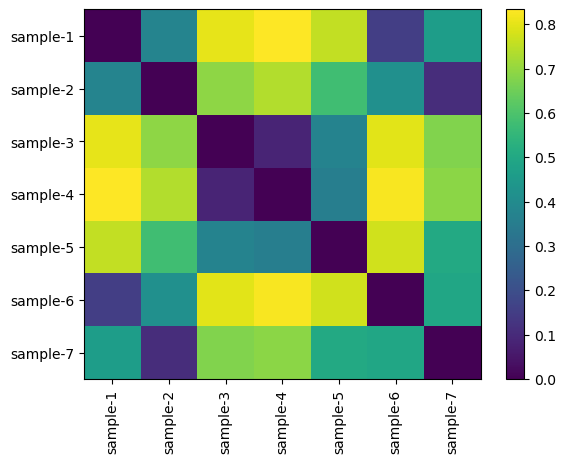

In [ ]:
import skbio.stats.distance as di
from qiime2.plugins.diversity.pipelines import beta
braycurtis = beta(otuFreqs, 'braycurtis')
dm = braycurtis.distance_matrix.view(di.DistanceMatrix)
dm

In [ ]:
faith.vector.view(pd.Series)

sample-1    2.163766
sample-2    0.770830
sample-3    1.166314
sample-4    0.813345
sample-5    0.806061
sample-6    1.547848
sample-7    0.806061
Name: faith_pd, dtype: float64

## Data sources

- https://www.ebi.ac.uk/ena/browser/view/PRJEB8518
- https://docs.qiime2.org/2023.5/data-resources/ High-quality reference OTUs
- The `see` and `v2frame` functions were obtained from [this](https://forum.qiime2.org/t/how-to-capture-a-value-from-a-summary-and-pipe-it/19783/5) link via user thermokarst
